<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages</a></span></li><li><span><a href="#Custom-functions" data-toc-modified-id="Custom-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Custom functions</a></span></li><li><span><a href="#Environment-variables" data-toc-modified-id="Environment-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Environment variables</a></span></li><li><span><a href="#Load-and-process-dataset" data-toc-modified-id="Load-and-process-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load and process dataset</a></span></li><li><span><a href="#Define-model-and-model-parameters" data-toc-modified-id="Define-model-and-model-parameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Define model and model parameters</a></span></li><li><span><a href="#Define-loss-and-accuracy-metrics" data-toc-modified-id="Define-loss-and-accuracy-metrics-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Define loss and accuracy metrics</a></span></li><li><span><a href="#Define-checkpoint-options" data-toc-modified-id="Define-checkpoint-options-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Define checkpoint options</a></span></li><li><span><a href="#Training-function-and-loop" data-toc-modified-id="Training-function-and-loop-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Training function and loop</a></span></li><li><span><a href="#Plot-loss-and-accuracy-graphs" data-toc-modified-id="Plot-loss-and-accuracy-graphs-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plot loss and accuracy graphs</a></span></li><li><span><a href="#Evaluate-model-and-test-prediction" data-toc-modified-id="Evaluate-model-and-test-prediction-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Evaluate model and test prediction</a></span></li></ul></div>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/My Drive/Colab Notebooks/accent/src

### Import packages

In [1]:
import re, zipfile, os, io, time, string, numpy as np, matplotlib.ticker as ticker, \
            matplotlib.pyplot as plt
import tensorflow as tf
from token_list import strip_tokens
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
# x = ['Khoan no cua KH se den han vao 01/08/2019. So tien  2.999.898 VND, TK 12345678912. Thong tin chi tiet, lien he 1900636633. Cam on',
# 'Khoan no cua KH se den han trong 2 ngay toi. So tien  2.999.898 VND, TK 12345678912. Bo qua neu da TT. Thong tin chi tiet, lien he 1900636633. Cam on',
# 'Khoan no cua KH da qua han 1 ngay. TK 12345678912, so tien2.999.898 VND. Bo qua neu da TT. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da qua han 6 ngay va bi tinh phat 250,000. TK 12345678912, so tien 2.999.898VND. Vui long TT. Thong tin chi tiet, lien he 18006288',
# 'KH da qua han 5 ky no. TK 12345678912, so tien 12.999.898VND. Vui long TT ngay lap tuc. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da bi tinh phat do lien tuc vi pham. TK12345678912, so tien 12.999.898VND. Vui long TT. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da qua han 91 ngay. Vui long TT toan bo29.999.898VND vao TK 12345678912 hom nay. Thong tin chi tiet, lien he 18006288',
# 'Chung toi vua nhan thanh toan khoan vay cua KH tu TK12345678912. TUY NHIEN, KH van con thieu 29.999.898VND. Vui long TT toan ngay lap tuc. Cam on']

### Custom functions

In [2]:
def process_raw(raw_data):
    raw_data = [seq.lower().strip() for seq in raw_data]

    # Creating a space between a word and the punctuation following it
    # Eg: "he is a boy." => "he is a boy ."
    raw_data = [re.sub(r"([?.!,¿])", r" \1 ", seq) for seq in raw_data]
    raw_data = [re.sub(r'[" "]+', " ", seq) for seq in raw_data]

    # Replacing everything with space except (characters, ".", "?", "!", ",")
    filtered_punctuations = string.punctuation
    exclude = [',', '!', '.', '?']

    for c in filtered_punctuations:
        if c in exclude:
            filtered_punctuations = filtered_punctuations.replace(c, '')

    table = str.maketrans('', '', filtered_punctuations)
    raw_data = [seq.translate(table) for seq in raw_data]
    
    # Append start and end tokens to sequences
    processed_raw = []
    for seq in raw_data:
        words = seq.split()
        words = [word.strip() for word in words]
        processed_raw.append(' '.join(words))

    processed_raw = ['<s> ' + seq + ' <e>' for seq in processed_raw]

    return processed_raw

In [3]:
def generate_input(processed_raw):
    output = ''
    for char in processed_raw:
        if char in strip_tokens:
            output += strip_tokens[char]
        else:
            output += char          
    return output

In [4]:
def get_max_len(input_data, get_index=False): 
    longest = [len(data.split()) for data in input_data]
    if get_index:
        print(longest.index(max(longest)))
    return max(longest)

In [5]:
def tokenize_pad_data(data, pad_len=None):
    tk = Tokenizer(char_level=False, filters='')
    tk.fit_on_texts(data)
    data = tk.texts_to_sequences(data)
    data = pad_sequences(data, padding='post', maxlen=pad_len)
    return data, tk

In [6]:
def process_data(processed_input, processed_target, pad_len=None):    
    tokenized_input, input_tokenizer = tokenize_pad_data(data=processed_input, pad_len=pad_len)
    tokenized_target, target_tokenizer = tokenize_pad_data(data=processed_target, pad_len=pad_len)
    return tokenized_input, input_tokenizer, tokenized_target, target_tokenizer

In [7]:
def convert(tokenizer, tokenized_data, send_back=False):
    original = []
    
    print('Tokenized Data: {}'.format(tokenized_data))
    print('\n')
    
    for token in tokenized_data:
        if token != 0:
            if token in tokenizer.index_word:
                original.append(tokenizer.index_word[token])
            else:
                original.append('<unk>')
                    
    print('Original Data: {}'.format(original))
    
    if send_back:
        return original

In [8]:
def evaluate(sentence):
    attention_plot = np.zeros((max_process_seq, max_process_seq))

#     sentence = preprocess_sentence(sentence)

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_process_seq, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = tf.zeros((1, units))
    cell = tf.zeros((1, units))
    enc_out, enc_hidden = encoder(inputs, hidden, cell)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['<s>']], 0)

    for t in range(max_process_seq):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizer.index_word[predicted_id] + ' '

        if target_tokenizer.index_word[predicted_id] == '<e>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
      
    return result, sentence, attention_plot

In [9]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [10]:
def restore(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Environment variables

In [11]:
# Define data arguements
# Set random seed
np.random.seed(50)
data_file = '../data/raw/raw_train.txt'

tf.__version__

'2.0.0'

### Load and process dataset

In [12]:
# Load dataset
counter = 0
max_seq_len = 40
no_seq = 50000
raw_data = []

# Load raw data and read first 100000 sequences with 40 or less words
with open(data_file, 'r', encoding='utf-8') as f:    
    while counter != no_seq:
        line = f.readline()
        if 10 <= len(line.split()) <= max_seq_len:
            raw_data.append(line)
            counter += 1
        else:
            continue

In [13]:
# Process dataset
# Shuffle raw data prior to processing
np.random.shuffle(raw_data)

# Process raw and input data
filtered_raw = process_raw(raw_data)
processed_inp = [generate_input(seq) for seq in filtered_raw]

# Get max sequence length after processing
max_process_seq = get_max_len(processed_inp, get_index=False)
print('Max input sequence length: {}'.format(get_max_len(processed_inp)))
print('Max target sequence length: {}'.format(get_max_len(filtered_raw)))

Max input sequence length: 52
Max target sequence length: 52


In [14]:
print('Input Sample:')
print(processed_inp[-1])
print('\n')
print('Target Sample:')
print(filtered_raw[-1])

Input Sample:
<s> chinh phu tay tang luu vong cho rang hang trieu nguoi trung hoa nhap cu vao vung tttt la de dong hoa nguoi tang thong qua van hoa va thong qua cac cuoc hon nhan di chung . <e>


Target Sample:
<s> chính phủ tây tạng lưu vong cho rằng hàng triệu người trung hoa nhập cư vào vùng tttt là để đồng hóa người tạng thông qua văn hóa và thông qua các cuộc hôn nhân dị chủng . <e>


In [15]:
# Tokenize/pad input and target data, generates corresponding tokenizers
tokenized_input, input_tokenizer, tokenized_target, target_tokenizer = process_data(processed_input=processed_inp, 
                                                            processed_target=filtered_raw, pad_len=max_process_seq)

In [16]:
train_data_len = round((.8 * no_seq))
val_test_data_len = round((.1 * no_seq))

train_inp_data, train_tar_data = tokenized_input[:train_data_len], tokenized_target[:train_data_len]
val_inp_data, val_tar_data = tokenized_input[train_data_len:(train_data_len+val_test_data_len)], \
                                    tokenized_target[train_data_len:(train_data_len+val_test_data_len)]
test_inp_data, test_tar_data = tokenized_input[-val_test_data_len:], tokenized_target[-val_test_data_len:]

print('Number of training sequences: {}'.format(len(train_inp_data)))
print('Number of val sequences: {}'.format(len(val_inp_data)))
print('Number of test sequences: {}'.format(len(test_inp_data)))

Number of training sequences: 40000
Number of val sequences: 5000
Number of test sequences: 5000


In [17]:
convert(input_tokenizer, train_inp_data[0])

Tokenized Data: [  2  73 115 764  15 119 359  23  71 115  70   6 811 550 255 225 677  23
 913 131  94 905   1   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


Original Data: ['<s>', 'ho', 'an', 'com', 'do', 'cach', 'thuy', 'voi', 'thuc', 'an', 'thuong', 'co', 'rau', 'rung', 'thai', 'nho', 'nau', 'voi', 'oc', 'hay', 'ca', 'suoi', '.', '<e>']


In [18]:
train_buffer_sz = len(train_inp_data)
val_buffer_sz = len(val_inp_data)
test_buffer_sz = len(test_inp_data)
batch_sz = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_inp_data, train_tar_data)).shuffle(train_buffer_sz)
train_dataset = train_dataset.batch(batch_sz, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((val_inp_data, val_tar_data)).shuffle(val_buffer_sz)
val_dataset = val_dataset.batch(batch_sz, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((test_inp_data, test_tar_data)).shuffle(test_buffer_sz)
test_dataset = test_dataset.batch(batch_sz, drop_remainder=True)

In [19]:
example_input_batch, example_target_batch = next(iter(train_dataset))
# example_input_batch.shape, example_target_batch.shape

example_val_inp_batch, example_val_tar_batch = next(iter(val_dataset))
# example_val_inp_batch.shape, example_val_tar_batch.shape

example_test_inp_batch, example_test_tar_batch = next(iter(test_dataset))
# example_test_inp_batch.shape, example_test_tar_batch.shape

### Define model and model parameters

In [20]:
embedding_dim = 256
units = 1024
dropout = 0.25
inp_vocab_sz = len(input_tokenizer.index_word)+1
tar_vocab_sz = len(target_tokenizer.index_word)+1

print('Input vocabulary: {}'.format(inp_vocab_sz))
print('Target vocabulary: {}'.format(tar_vocab_sz))

Input vocabulary: 21926
Target vocabulary: 25711


In [21]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super().__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#     self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform', dropout=dropout)
    self.gru = tf.keras.layers.LSTM(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform', dropout=dropout)

            
  def call(self, x, hidden, cell):
    x = self.embedding(x)
    output, state, cell = self.gru(x, initial_state = [hidden, cell])
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

  def initialize_cell_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [22]:
encoder = Encoder(inp_vocab_sz, embedding_dim, units, batch_sz)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_cell = encoder.initialize_cell_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden, sample_cell)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden[0].shape))

Encoder output shape: (batch size, sequence length, units) (32, 52, 1024)
Encoder Hidden state shape: (batch size, units) (1024,)


In [23]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super().__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [24]:
attention_layer = BahdanauAttention(128)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (32, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (32, 52, 1)


In [25]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super().__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#     self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform', dropout=dropout)
    self.gru = tf.keras.layers.LSTM(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform', dropout=dropout)
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state, cell = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [26]:
decoder = Decoder(tar_vocab_sz, embedding_dim, units, batch_sz)

sample_decoder_output, _, _ = decoder(tf.random.uniform((batch_sz, 1)), sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 25711)


### Define loss and accuracy metrics

In [27]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

### Define checkpoint options

In [28]:
checkpoint_dir = './training_checkpoints'
  
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
manager = tf.train.CheckpointManager(checkpoint=checkpoint, directory=checkpoint_dir, max_to_keep=1)

### Training function and loop

In [29]:
@tf.function
def train_step(inp, targ, enc_hidden, enc_cell):
    loss = 0.0
    acc = 0.0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden, enc_cell)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([target_tokenizer.word_index['<s>']] * batch_sz, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_object(targ[:, t], predictions)           
    
            train_accuracy.update_state(targ[:, t], predictions)
            acc += train_accuracy.result()
            
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
      
    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))
    
    batch_loss = loss / int(targ.shape[1])
    batch_acc = acc / int (targ.shape[1])
    
    return batch_loss, batch_acc

In [30]:
@tf.function
def test_step(inp, targ, enc_hidden, enc_cell):
  loss = 0.0
  acc = 0.0
  
  enc_output, enc_hidden = encoder(inp, enc_hidden, enc_cell)

  dec_hidden = enc_hidden

  dec_input = tf.expand_dims([target_tokenizer.word_index['<s>']] * batch_sz, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    # passing enc_output to the decoder
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss += loss_object(targ[:, t], predictions)
    
    val_accuracy(targ[:, t], predictions)    
    val_accuracy.update_state(targ[:, t], predictions)
    acc += val_accuracy.result()
            
    # using teacher forcing
    dec_input = tf.expand_dims(targ[:, t], 1)
    
  batch_loss = loss / int(targ.shape[1])
  batch_acc = acc / int (targ.shape[1])
    
  return batch_loss, batch_acc

In [69]:
epochs = 50
train_steps_per_epoch = len(train_inp_data)//batch_sz
val_steps_per_epoch = len(val_inp_data)//batch_sz
# best_val_loss = np.inf
best_val_loss = 1.2952
train_epoch_losses = []
train_epoch_accs = []
val_epoch_losses = []
val_epoch_accs = []
early_stop = 0

for epoch in range(epochs):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  enc_cell = encoder.initialize_cell_state()
  train_total_loss = 0.0
  train_total_acc = 0.0
  val_total_loss = 0.0
  val_total_acc = 0.0
    
  # Training
  for (batch, (inp, targ)) in enumerate(train_dataset.take(train_steps_per_epoch)):
    train_batch_loss, train_batch_acc = train_step(inp, targ, enc_hidden, enc_cell)
    train_total_loss += np.average(train_batch_loss)
    train_total_acc += train_batch_acc
        
    if batch % 100 == 0:
      print('Epoch: {}, Batch: {}, Loss: {:.4f}'.format(epoch+1, batch, np.average(train_batch_loss)))
      
  # Training
  train_epoch_loss = train_total_loss/train_steps_per_epoch 
  train_epoch_losses.append(train_epoch_loss)
  
  train_epoch_acc = train_total_acc/train_steps_per_epoch
  train_epoch_accs.append(train_epoch_acc)    
      
  # Validation
  for (_, (inp, targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
    val_batch_loss, val_batch_acc = test_step(inp, targ, enc_hidden, enc_cell)
    val_total_loss += np.average(val_batch_loss)
    val_total_acc += val_batch_acc
  
  # Validation
  val_epoch_loss = val_total_loss/val_steps_per_epoch    
  val_epoch_losses.append(val_epoch_loss)

  val_epoch_acc = val_total_acc/val_steps_per_epoch
  val_epoch_accs.append(val_epoch_acc)
    
  if val_epoch_loss <= best_val_loss:
    print('New best val loss: {:.4f} --> {:.4f}'.format(best_val_loss, val_epoch_loss))
    best_val_loss = val_epoch_loss
    print('New val loss: {:.4f}'.format(best_val_loss))
    print('Saving model')
    manager.save()
    print('Save completed')
    print('Resetting Early Stop counter')
    early_stop = 0
  else:
    early_stop += 1
    print('Increasing Early Stop count to: {}'.format(early_stop))
    if early_stop == 5:
      print('Loss has not improved for {} epochs, Early Stoppping'.format(early_stop))
      break
      
  train_template = 'Epoch {} Training Loss {:.4f}, Training Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
  print(train_template.format(epoch + 1, train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc))
  print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))

  train_accuracy.reset_states()
  val_accuracy.reset_states()

Epoch: 1, Batch: 0, Loss: 1.0267
Epoch: 1, Batch: 100, Loss: 1.0518
Epoch: 1, Batch: 200, Loss: 2.0088
Epoch: 1, Batch: 300, Loss: 1.1275
Epoch: 1, Batch: 400, Loss: 1.3208
Epoch: 1, Batch: 500, Loss: 2.3576
Epoch: 1, Batch: 600, Loss: 2.3840
Epoch: 1, Batch: 700, Loss: 1.7409
Epoch: 1, Batch: 800, Loss: 1.3154
Epoch: 1, Batch: 900, Loss: 0.9696
Epoch: 1, Batch: 1000, Loss: 1.0912
Epoch: 1, Batch: 1100, Loss: 0.9911
Epoch: 1, Batch: 1200, Loss: 2.8819
Increasing Early Stop count to: 1
Epoch 1 Training Loss 1.6278, Training Acc: 0.7320, Val Loss: 2.6076, Val Acc: 0.5930
Time taken for 1 epoch 851.0876 sec

Epoch: 2, Batch: 0, Loss: 2.2498
Epoch: 2, Batch: 100, Loss: 1.0615
Epoch: 2, Batch: 200, Loss: 0.9197
Epoch: 2, Batch: 300, Loss: 0.7795
Epoch: 2, Batch: 400, Loss: 1.0495
Epoch: 2, Batch: 500, Loss: 0.7576
Epoch: 2, Batch: 600, Loss: 1.2537
Epoch: 2, Batch: 700, Loss: 1.4016
Epoch: 2, Batch: 800, Loss: 0.8507
Epoch: 2, Batch: 900, Loss: 0.8098
Epoch: 2, Batch: 1000, Loss: 2.0983
Epo

Epoch: 13, Batch: 1100, Loss: 0.3646
Epoch: 13, Batch: 1200, Loss: 1.5753
Increasing Early Stop count to: 2
Epoch 13 Training Loss 1.1980, Training Acc: 0.7172, Val Loss: 1.1449, Val Acc: 0.8113
Time taken for 1 epoch 896.7790 sec

Epoch: 14, Batch: 0, Loss: 0.8736
Epoch: 14, Batch: 100, Loss: 0.4183
Epoch: 14, Batch: 200, Loss: 0.4330
Epoch: 14, Batch: 300, Loss: 0.4813
Epoch: 14, Batch: 400, Loss: 0.3760
Epoch: 14, Batch: 500, Loss: 0.4912
Epoch: 14, Batch: 600, Loss: 0.3317
Epoch: 14, Batch: 700, Loss: 1.3911
Epoch: 14, Batch: 800, Loss: 0.6016
Epoch: 14, Batch: 900, Loss: 0.5850
Epoch: 14, Batch: 1000, Loss: 0.5086
Epoch: 14, Batch: 1100, Loss: 0.3956
Epoch: 14, Batch: 1200, Loss: 0.4446
Increasing Early Stop count to: 3
Epoch 14 Training Loss 0.5082, Training Acc: 0.8728, Val Loss: 0.7378, Val Acc: 0.8743
Time taken for 1 epoch 891.2369 sec

Epoch: 15, Batch: 0, Loss: 0.4298
Epoch: 15, Batch: 100, Loss: 0.3582
Epoch: 15, Batch: 200, Loss: 0.6604
Epoch: 15, Batch: 300, Loss: 0.4366

### Plot loss and accuracy graphs

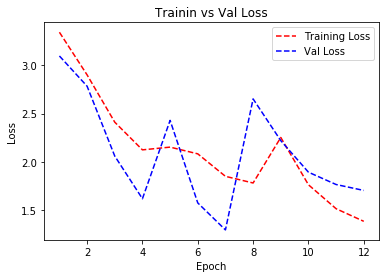

In [35]:
# Plot training vs val loss
epoch_range = [i for i in range(1, len(train_epoch_losses)+1)]
plt.plot(epoch_range, train_epoch_losses, 'r--')
plt.plot(epoch_range, val_epoch_losses, 'b--')
plt.title('Training vs Val Loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

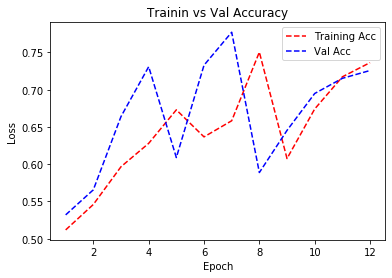

In [36]:
# Plot training vs val accuracy
epoch_range = [i for i in range(1, len(train_epoch_losses)+1)]
plt.plot(epoch_range, train_epoch_accs, 'r--')
plt.plot(epoch_range, val_epoch_accs, 'b--')
plt.title('Training vs Val Accuracy')
plt.legend(['Training Acc', 'Val Acc'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Evaluate model and test prediction

In [31]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(manager.latest_checkpoint)

In [71]:
# Testing
test_steps_per_epoch = len(test_inp_data)//batch_sz
test_total_loss = 0.0
test_total_acc = 0.0
test_loss = 0.0
test_acc = 0.0
enc_hidden = encoder.initialize_hidden_state()
enc_cell = encoder.initialize_cell_state()

for (_, (inp, targ)) in enumerate(test_dataset.take(test_steps_per_epoch)):
  test_batch_loss, test_batch_acc = test_step(inp, targ, enc_hidden, enc_cell)
  test_total_loss += np.average(test_batch_loss)
  test_total_acc += test_batch_acc

# Testing
test_loss = test_total_loss/test_steps_per_epoch    
# test_epoch_losses.append(test_epoch_loss)

test_acc = test_total_acc/test_steps_per_epoch
# test_epoch_accs.append(test_epoch_acc)

print('Testing Loss: {:.4f}, Acc: {:.4f}'.format(test_loss, test_acc))
val_accuracy.reset_states()

Testing Loss: 0.6707, Acc: 0.8348


In [70]:
rand = np.random.randint(0, len(test_inp_data)) # Change here
test = test_inp_data[rand] # Change here
test = convert(input_tokenizer, test, send_back=True)
test = ' '.join(test)
print('Test Sequence: {}'.format(test))

Tokenized Data: [    2    14   454   147   135    78     5    61 21371    75   149    29
     6     9   108   122   166   501    86    25   406    96    28    11
   744     9   209    39    41   213    99     1     3     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


Original Data: ['<s>', 'tu', 'lenh', 'toi', 'cao', 'moi', 'la', 'tuong', 'ridgway', 'tien', 'hanh', 'cung', 'co', 'cac', 'luc', 'luong', 'lien', 'hiep', 'quoc', 'de', 'chuan', 'bi', 'cho', 'mot', 'loat', 'cac', 'cuoc', 'phan', 'cong', 'hieu', 'qua', '.', '<e>']
Test Sequence: <s> tu lenh toi cao moi la tuong ridgway tien hanh cung co cac luc luong lien hiep quoc de chuan bi cho mot loat cac cuoc phan cong hieu qua . <e>


Tokenized Data: [    2   254   566   652   105   196     5   323 25115   266   112  1841
   638     8   146   100   141   691    47    31   449    63    19    11
  1292     8   154   426    42   233   316     1     3     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


Original Data: ['<s>', 'tư', 'lệnh', 'tối', 'cao', 'mới', 'là', 'tướng', 'ridgway', 'tiến', 'hành', 'củng', 'cố', 'các', 'lực', 'lượng', 'liên', 'hiệp', 'quốc', 'để', 'chuẩn', 'bị', 'cho', 'một', 'loạt', 'các', 'cuộc', 'phản', 'công', 'hiệu', 'quả', '.', '<e>']
Original: <s> tư lệnh tối cao mới là tướng ridgway tiến hành củng cố các lực lượng liên hiệp quốc để chuẩn bị cho một loạt các cuộc phản công hiệu quả . <e>
Input: <s> tu lenh toi cao moi la tuong ridgway tien hanh cung co cac luc luong lien hiep quoc de chuan bi cho mot loat cac cuoc phan cong hieu qua . <e>
Predicted translation: từ chối tới cao mới là tương ưng phải hành cũng có các lực lượng liê

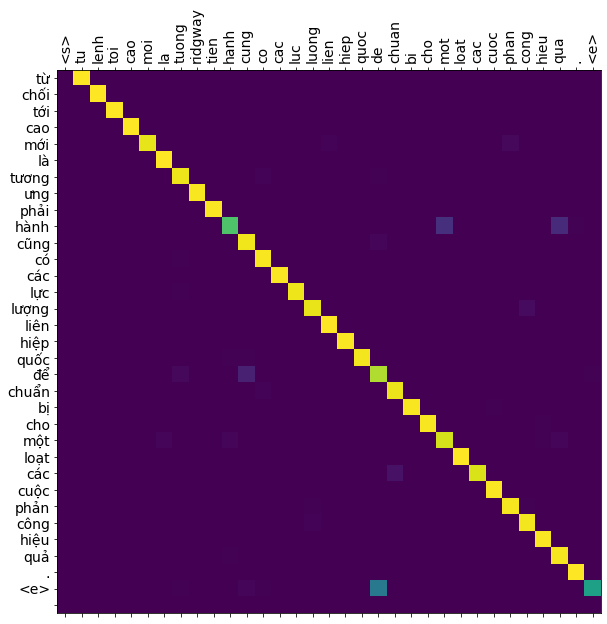

In [71]:
test_tar = convert(target_tokenizer, test_tar_data[rand], send_back=True) # Change here
test_tar = ' '.join(test_tar)
print('Original: {}'.format(test_tar))
restore(test)

In [88]:
rand = np.random.randint(0, len(test_inp_data)) # Change here
test = test_inp_data[rand] # Change here
test = convert(input_tokenizer, test, send_back=True)
test = ' '.join(test)
print('Test Sequence: {}'.format(test))

Tokenized Data: [  2  36 113   4  28  40  74 224  85 224  13 611   4 457 555 109 187  73
   7  18  49  82 370  64   1   3   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


Original Data: ['<s>', 'tai', 'phap', ',', 'cho', 'den', 'ngay', '1', 'thang', '1', 'nam', '2005', ',', 'tre', 'em', 'phai', 'mang', 'ho', 'cua', 'nguoi', 'bo', 'theo', 'luat', 'dinh', '.', '<e>']
Test Sequence: <s> tai phap , cho den ngay 1 thang 1 nam 2005 , tre em phai mang ho cua nguoi bo theo luat dinh . <e>


Tokenized Data: [  2  36  66   4  19  27  51 172  68 172  14 979   4 707 857  89 324 119
   6  13 480  46 375  71   1   3   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


Original Data: ['<s>', 'tại', 'pháp', ',', 'cho', 'đến', 'ngày', '1', 'tháng', '1', 'năm', '2005', ',', 'trẻ', 'em', 'phải', 'mang', 'họ', 'của', 'người', 'bố', 'theo', 'luật', 'định', '.', '<e>']
Original: <s> tại pháp , cho đến ngày 1 tháng 1 năm 2005 , trẻ em phải mang họ của người bố theo luật định . <e>
Input: <s> tai phap , cho den ngay 1 thang 1 nam 2005 , tre em phai mang ho cua nguoi bo theo luat dinh . <e>
Predicted translation: tại pháp , cho đến ngày 1 tháng 1 năm 2005 , trẻ em phải mang họ của người bồ theo luật định . <e> 


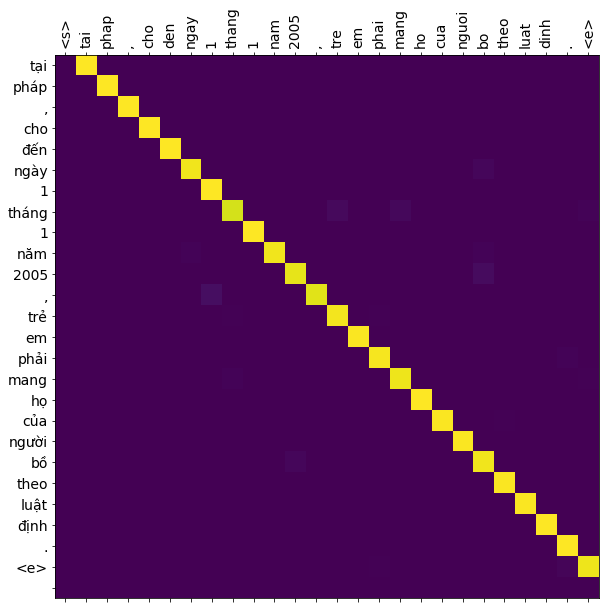

In [89]:
test_tar = convert(target_tokenizer, test_tar_data[rand], send_back=True) # Change here
test_tar = ' '.join(test_tar)
print('Original: {}'.format(test_tar))
restore(test)

In [ ]:
tại pháp , cho đến ngày 1 tháng 1 năm 2005 , trẻ em phải mang họ của người bố theo luật định . <e>
tại pháp , cho đến ngày 1 tháng 1 năm 2005 , trẻ em phải mang họ của người bồ theo luật định . <e> 